In [89]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

# READING THE DATA

In [37]:
# LOAD THE DATASET
df = pd.read_csv('housing.csv')

In [38]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


### Insights:
#### There are only a few missing values in total_bedrooms and the min and max value are extremely far away for a few columns. We have to visualise the data and see if the data is skewed or not.

# EDA

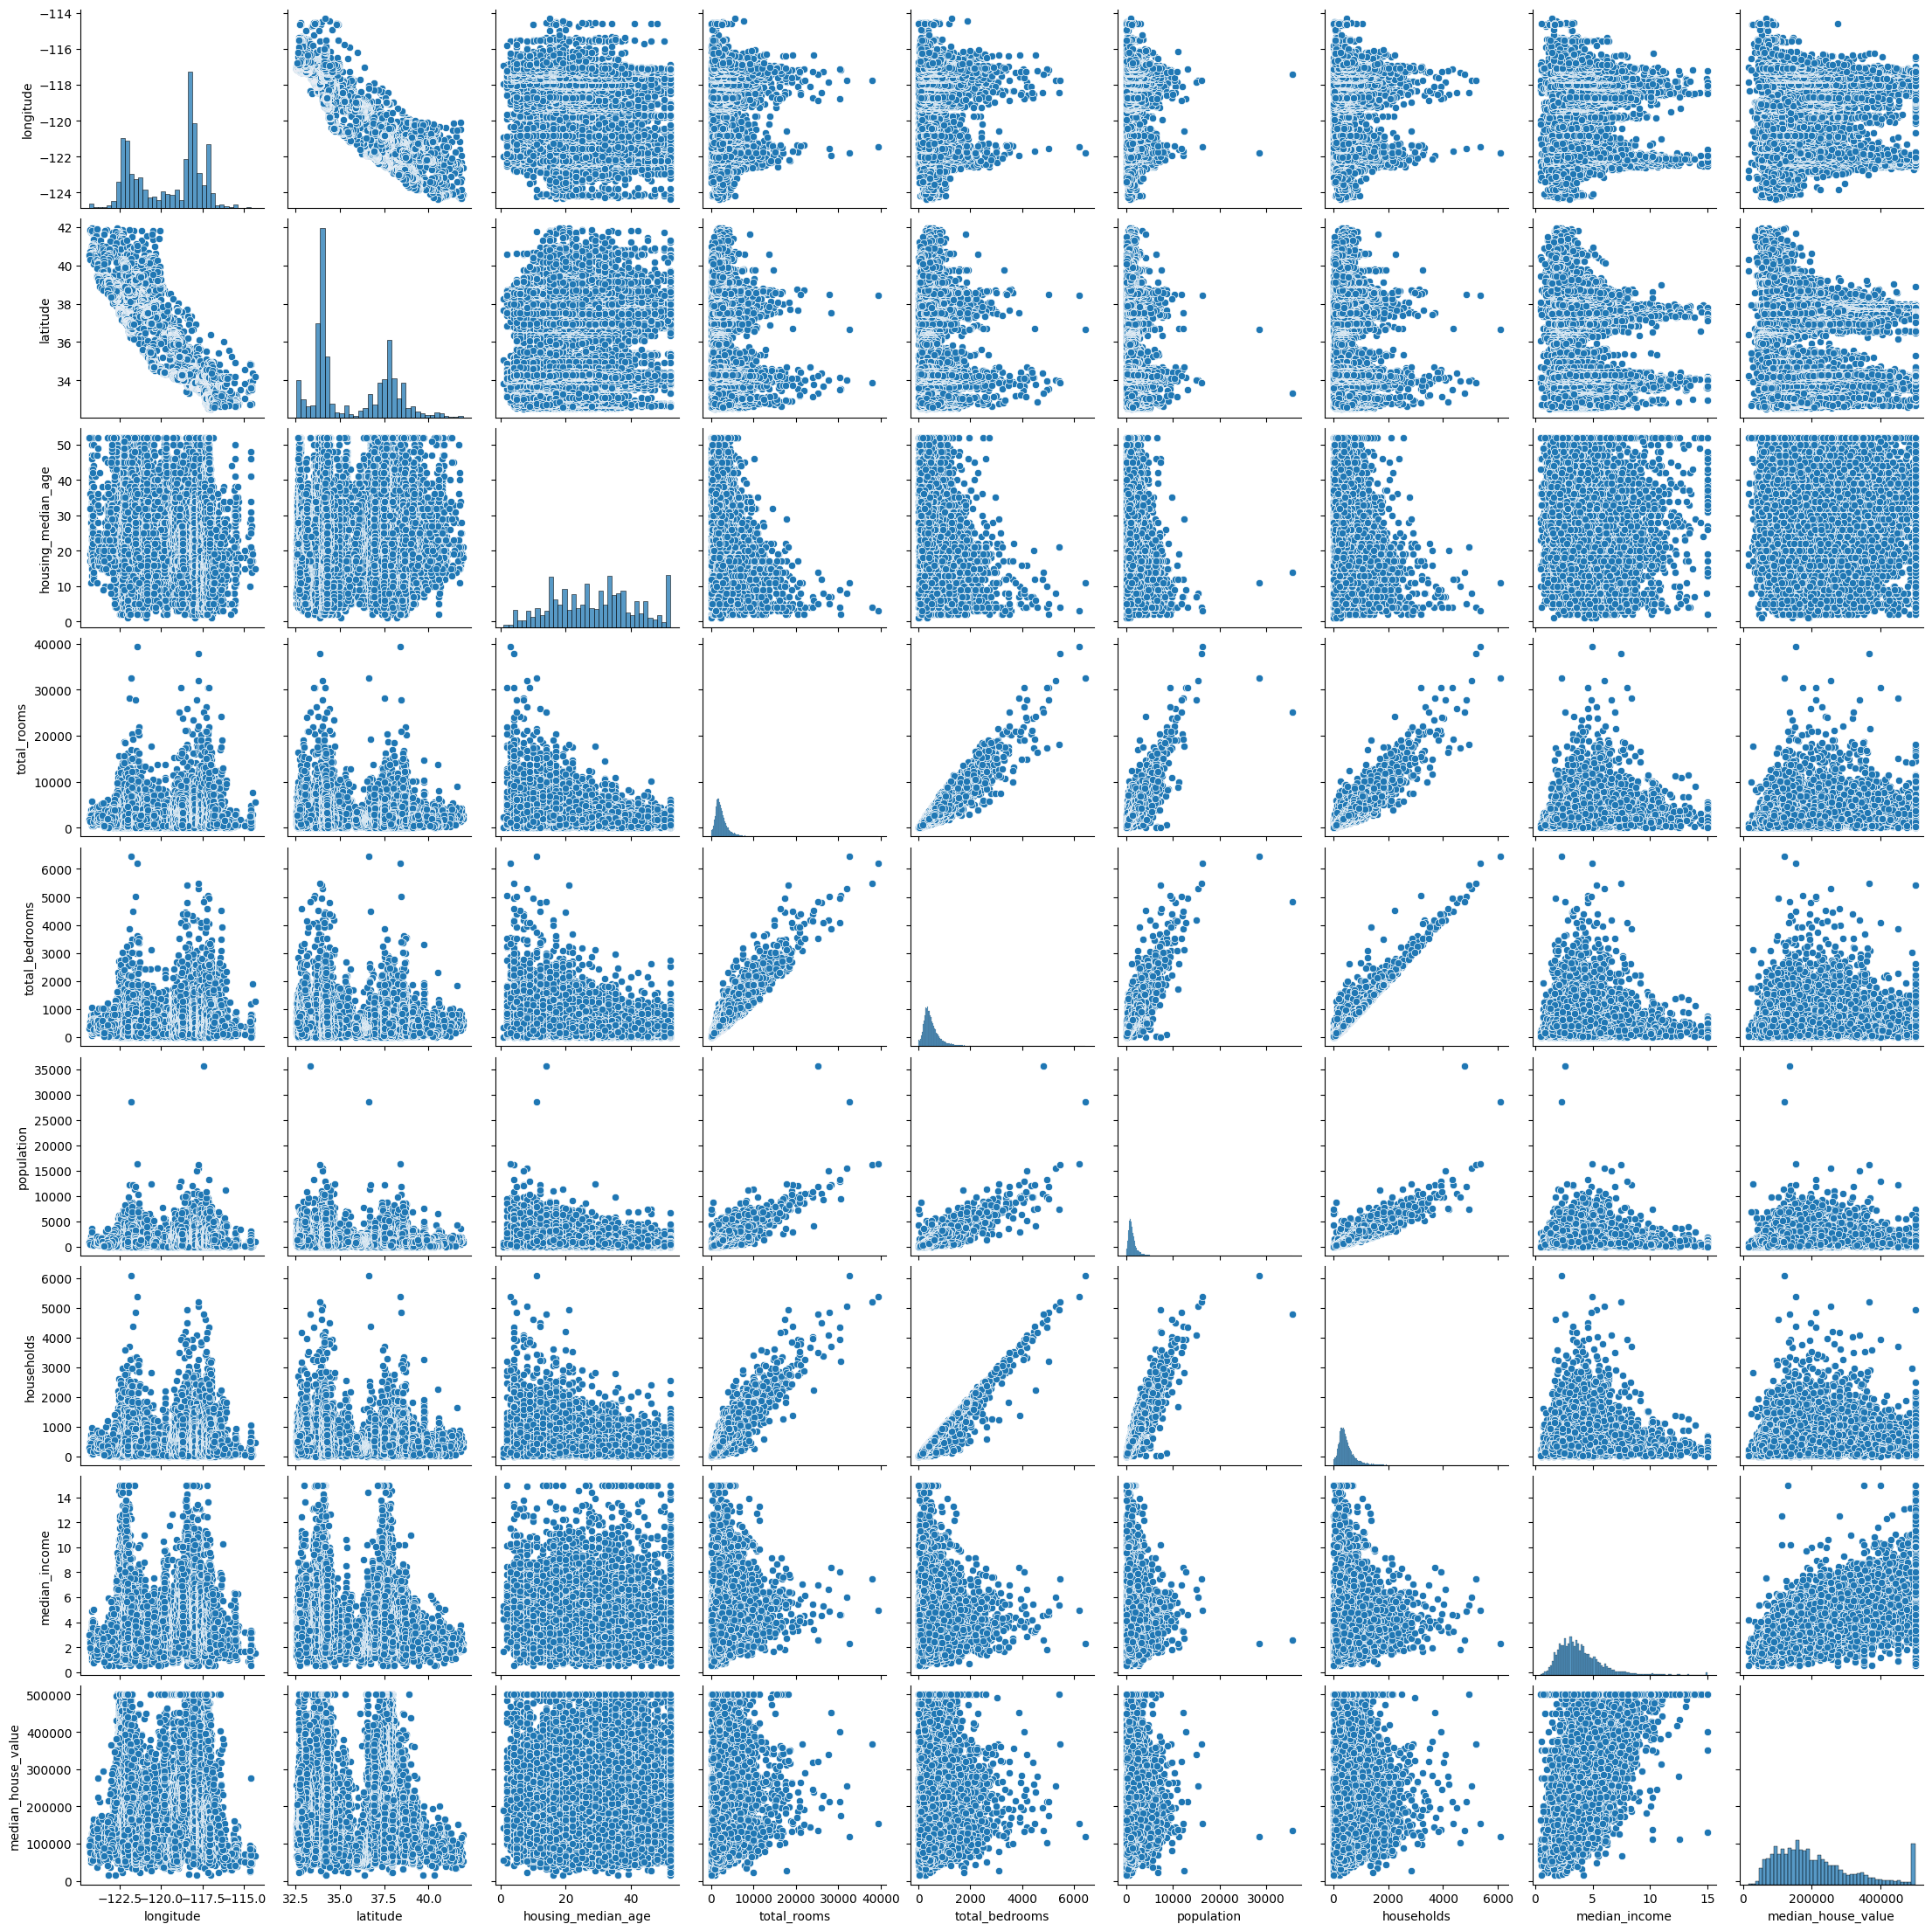

In [41]:
sns.pairplot(df)

#### There is high proportionality with columns total_rooms and total_bedrooms

<Axes: xlabel='latitude', ylabel='longitude'>

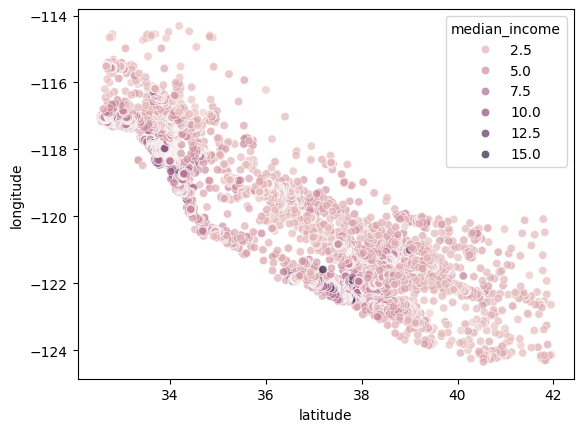

In [42]:
sns.scatterplot(data=df,x=df['latitude'],y=df['longitude'],hue=df['median_income'],alpha=0.7)

#### The more expensive houses seem to have lower latitude and longitude

<Axes: xlabel='count', ylabel='ocean_proximity'>

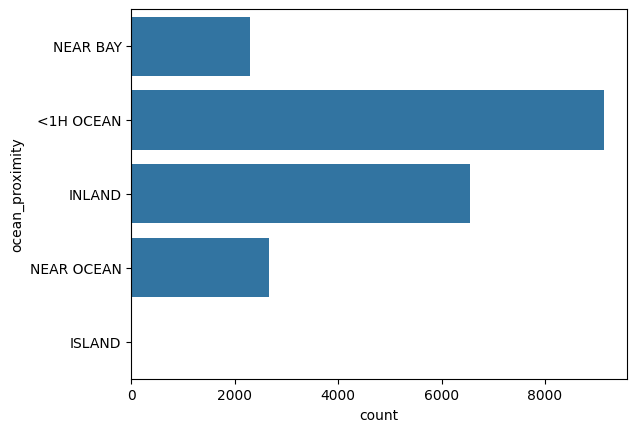

In [43]:
sns.countplot(df['ocean_proximity'])

#### It looks like there are less houses near the ocean and more houses far away from the ocean.

<Axes: xlabel='median_house_value', ylabel='median_income'>

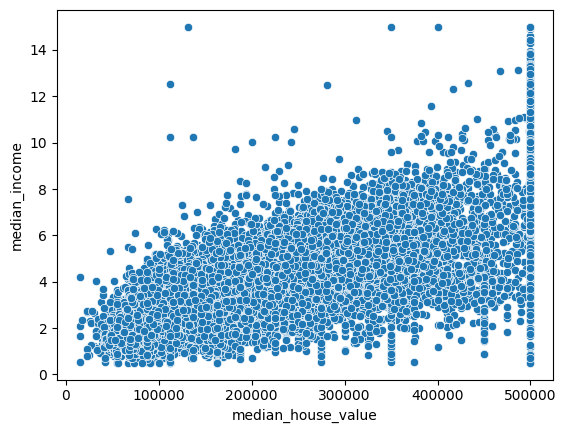

In [44]:
sns.scatterplot(data=df,x=df['median_house_value'],y=df['median_income'])

#### It seems like if a person has low median income, even then he owns a house with large value. This shows how a human feels inferior to someone if the value of his house is lower than the other person. There are only a few people with high median income and a house with low price.

<Axes: xlabel='total_bedrooms', ylabel='total_rooms'>

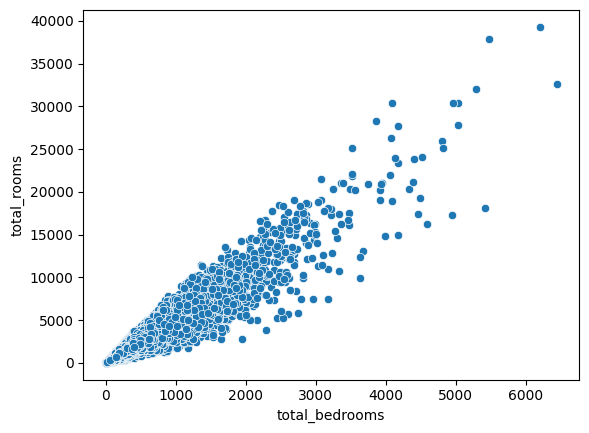

In [45]:
sns.scatterplot(data=df,x=df['total_bedrooms'],y=df['total_rooms'])

In [46]:
df.drop('ocean_proximity',axis=1).corr()['median_house_value']

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

<Axes: >

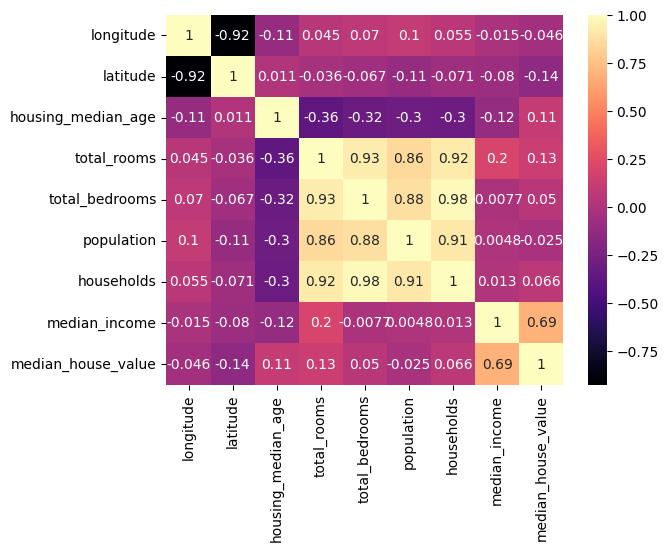

In [47]:
sns.heatmap(df.drop('ocean_proximity',axis=1).corr(),cmap='magma',annot=True)

#### From the correlation graph, we can observe alot.
1. The house price increases as the income of the person increases. 
2. The correlation between total_rooms, total_bedrooms, population and households is extremely high(~0.9) which can cause multicollinearity.


# DATA PROCESSING

In [48]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Handling missing values.

In [49]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [50]:
np.log1p(df['total_bedrooms']).skew()
# the plot is skewed even after log transformation, so i will fill the null values with median of the values.

-0.9928134853509126

In [51]:
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(),inplace=True)

#### Handling duplicate values

In [52]:
df.duplicated().sum()
# There are no duplicate values.

0

#### Fixing the skewness of data

In [53]:
df.drop('ocean_proximity',axis=1).skew()

longitude            -0.297801
latitude              0.465953
housing_median_age    0.060331
total_rooms           4.147343
total_bedrooms        3.477023
population            4.935858
households            3.410438
median_income         1.646657
median_house_value    0.977763
dtype: float64

In [54]:
# The skewness of lat, long and house_median_age is fine but the rest can be fixed
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df[['total_rooms','total_bedrooms','population','households']] = pt.fit_transform(df[['total_rooms','total_bedrooms','population','households']])

In [55]:
df['median_income'] = np.log1p(df['median_income'])
df['median_house_value'] = np.log1p(df['median_house_value'])

#### Transforming Categorical columns

In [56]:
# since the unique values of ocean proximity dont have any inherent order, we will use dummies.
ocean_dummies = pd.get_dummies(df['ocean_proximity'])

In [57]:
df = pd.concat([df,ocean_dummies],axis=1)

In [58]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,-1.158227,-1.581875,-1.619967,-1.521093,2.232720,13.022766,NEAR BAY,False,False,False,True,False
1,-122.22,37.86,21.0,1.896146,1.441859,1.090355,1.633844,2.230165,12.789687,NEAR BAY,False,False,False,True,False
2,-122.24,37.85,52.0,-0.534616,-1.138381,-1.139853,-1.136367,2.111110,12.771673,NEAR BAY,False,False,False,True,False
3,-122.25,37.85,52.0,-0.713802,-0.877999,-1.000270,-0.878626,1.893579,12.740520,NEAR BAY,False,False,False,True,False
4,-122.25,37.85,52.0,-0.399535,-0.653866,-0.985268,-0.665985,1.578195,12.743154,NEAR BAY,False,False,False,True,False


In [59]:
df.drop('ocean_proximity',axis=1,inplace=True)

# FEATURE ENGINEERING

In [60]:
df['non_bedroom_rooms'] = df['total_rooms'] - df['total_bedrooms']

In [61]:
df['rooms_per_household'] = df['total_rooms'] / df['households']

In [62]:
df['population_per_household'] = df['population'] / df['households']

#### Lets check the skewness of the engineered columns again. If the skewness is high, we will powertransform them.

In [63]:
df.skew()

longitude                   -0.297801
latitude                     0.465953
housing_median_age           0.060331
total_rooms                  0.121378
total_bedrooms               0.108136
population                   0.110641
households                   0.109520
median_income                0.226083
median_house_value          -0.173166
<1H OCEAN                    0.230999
INLAND                       0.784682
ISLAND                      64.230833
NEAR BAY                     2.477658
NEAR OCEAN                   2.216702
non_bedroom_rooms           -0.581667
rooms_per_household         22.599593
population_per_household   -31.477807
dtype: float64

#### The skewness of ISLAND, near bay, near ocean, rooms per household and pop per household is very high. so we will transform these columns.

In [64]:
df[['rooms_per_household','population_per_household']] = pt.fit_transform(df[['rooms_per_household','population_per_household']])

# MODEL BUILDING

 Since i had multicollinearity issue with 4 columns of the dataset, i am going to make 4 datasets: 1 with none dropped, one with 1 dropped, one with 2 dropped and one with 3 dropped to see how it affects my accuracy r2 score

In [65]:
df_1 = df.drop('households',axis=1)

In [66]:
df_2 = df.drop(['households','total_bedrooms'],axis=1)

In [67]:
df_3 = df.drop(['households','total_bedrooms','total_rooms'],axis=1)

## Linear Regression

#### Splitting the data into test and train, applying the regression model and getting the mse and r2 score for all datasets

In [68]:

datasets = [df,df_1,df_2,df_3]

target_col = 'median_house_value'

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()  
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")



=== Dataset 1 ===
MSE: 0.1074
R² Score: 0.6691

=== Dataset 2 ===
MSE: 0.1117
R² Score: 0.6557

=== Dataset 3 ===
MSE: 0.1117
R² Score: 0.6557

=== Dataset 4 ===
MSE: 0.1190
R² Score: 0.6332


#### Implementing Grid Search

In [ ]:
datasets = [df,df_1,df_2,df_3]

target_col = 'median_house_value'

results = []

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    start_time = time.time()

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define pipeline: StandardScaler + LinearRegression
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])

    param_grid = {
        'lr__fit_intercept': [True, False],
        'lr__positive': [False, True]
    }

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    time_taken = time.time() - start_time


    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Time taken: {time_taken:.2f} seconds")

    results.append({
        'Dataset': f'Dataset {i}',
        'MSE': mse,
        'R2': r2,
        'Best Params': grid_search.best_params_,
        'Time (s)': time_taken
    })


results_df = pd.DataFrame(results)
print("\n=== Summary ===")
print(results_df)



=== Dataset 1 ===
Best Params: {'lr__fit_intercept': True, 'lr__positive': False}
MSE: 0.1190
R² Score: 0.6332
Time taken: 1.91 seconds

=== Dataset 2 ===
Best Params: {'lr__fit_intercept': True, 'lr__positive': False}
MSE: 0.1117
R² Score: 0.6557
Time taken: 0.21 seconds

=== Dataset 3 ===
Best Params: {'lr__fit_intercept': True, 'lr__positive': False}
MSE: 0.1117
R² Score: 0.6557
Time taken: 0.12 seconds

=== Dataset 4 ===
Best Params: {'lr__fit_intercept': True, 'lr__positive': False}
MSE: 0.1190
R² Score: 0.6332
Time taken: 0.11 seconds

=== Summary ===
     Dataset       MSE        R2  \
0  Dataset 1  0.119048  0.633202   
1  Dataset 2  0.111737  0.655730   
2  Dataset 3  0.111737  0.655730   
3  Dataset 4  0.119048  0.633202   

                                         Best Params  Time (s)  
0  {'lr__fit_intercept': True, 'lr__positive': Fa...  1.914383  
1  {'lr__fit_intercept': True, 'lr__positive': Fa...  0.210158  
2  {'lr__fit_intercept': True, 'lr__positive': Fa...  0.122

### Summary for Linear Regression

#### After training multiple models, our best r2 score is: 0.6691 and the best MSE is: 0.1074 from our normal df from which we didnt remove any columns causing multicollinearity. 

## DECISION TREE

#### Using a loop to train and fit all the datasets and get their evaluation.

In [70]:
datasets = [df,df_1,df_2,df_3]

target_col = 'median_house_value'

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")



=== Dataset 1 ===
MSE: 0.1035
R² Score: 0.6810

=== Dataset 2 ===
MSE: 0.1046
R² Score: 0.6776

=== Dataset 3 ===
MSE: 0.1056
R² Score: 0.6746

=== Dataset 4 ===
MSE: 0.1078
R² Score: 0.6677


#### INSIGHTS : there is no advantage in applying a decision tree on this dataset as there is only a 1.2% increase in accuracy.

## Random Forest

#### Using a loop to fit and train a model on all the datasets.

In [72]:
datasets = [df,df_1,df_2,df_3]

target_col = 'median_house_value'

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor()  
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")


=== Dataset 1 ===
MSE: 0.0545
R² Score: 0.8322

=== Dataset 2 ===
MSE: 0.0543
R² Score: 0.8328

=== Dataset 3 ===
MSE: 0.0541
R² Score: 0.8333

=== Dataset 4 ===
MSE: 0.0541
R² Score: 0.8333


#### INSIGHTS by applying random forest method by accuracy increased from 68.2% to 83.3%. thus this is the most accurate model by far

### Applying GridSearchCV on random forest.

In [81]:
datasets = [df, df_1, df_2, df_3]
target_col = 'median_house_value'
results = []

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    start_time = time.time()

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Pipeline: StandardScaler + RandomForestRegressor
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor())
    ])

    # Randomized search parameter grid
    param_dist = {
        "rf__n_estimators": randint(50, 200),
        "rf__max_depth": randint(5, 30),
        "rf__min_samples_split": randint(2, 10),
        "rf__min_samples_leaf": randint(1, 10)
    }

    grid_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        cv=5,
        n_iter=50,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    time_taken = time.time() - start_time

    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Time taken: {time_taken:.2f} seconds")

    results.append({
        'Dataset': f'Dataset {i}',
        'MSE': mse,
        'R2': r2,
        'Best Params': grid_search.best_params_,
        'Time (s)': time_taken
    })

results_df = pd.DataFrame(results)
print("\n=== Summary ===")
print(results_df)



=== Dataset 1 ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'rf__max_depth': 24, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 4, 'rf__n_estimators': 160}
MSE: 0.0545
R² Score: 0.8321
Time taken: 208.14 seconds

=== Dataset 2 ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'rf__max_depth': 24, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 199}
MSE: 0.0538
R² Score: 0.8342
Time taken: 323.04 seconds

=== Dataset 3 ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'rf__max_depth': 27, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 167}
MSE: 0.0536
R² Score: 0.8348
Time taken: 235.24 seconds

=== Dataset 4 ===
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'rf__max_depth': 18, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 4, 'rf__n_estimators': 170}
MSE: 0.0543
R² Score: 0.8328
Time taken: 251.39 

#### Insights: This took a long time to train but increased the accuracy by negligible margin. Honestly not recommended as it took a lot of time to run.

## CatBoost 

#### Fitting and training all the 4 models using a loop

In [84]:

datasets = [df,df_1,df_2,df_3]

target_col = 'median_house_value'

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = CatBoostRegressor()  
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")



=== Dataset 1 ===
Learning rate set to 0.063766
0:	learn: 0.5466321	total: 58.7ms	remaining: 58.6s
1:	learn: 0.5256093	total: 59.7ms	remaining: 29.8s
2:	learn: 0.5067330	total: 60.7ms	remaining: 20.2s
3:	learn: 0.4897435	total: 61.7ms	remaining: 15.4s
4:	learn: 0.4738126	total: 62.7ms	remaining: 12.5s
5:	learn: 0.4600547	total: 63.6ms	remaining: 10.5s
6:	learn: 0.4464329	total: 64.5ms	remaining: 9.15s
7:	learn: 0.4341965	total: 65.4ms	remaining: 8.11s
8:	learn: 0.4225692	total: 66.4ms	remaining: 7.31s
9:	learn: 0.4121118	total: 67.3ms	remaining: 6.66s
10:	learn: 0.4025103	total: 68.2ms	remaining: 6.13s
11:	learn: 0.3938114	total: 69.1ms	remaining: 5.69s
12:	learn: 0.3860044	total: 70.3ms	remaining: 5.33s
13:	learn: 0.3789280	total: 71.1ms	remaining: 5.01s
14:	learn: 0.3722703	total: 71.9ms	remaining: 4.72s
15:	learn: 0.3660129	total: 72.8ms	remaining: 4.48s
16:	learn: 0.3607290	total: 73.7ms	remaining: 4.26s
17:	learn: 0.3555634	total: 74.5ms	remaining: 4.07s
18:	learn: 0.3509136	tota

#### Insights: Holy fuck that was fast and accurate.

#### Using RandomizedSearchCV on Catboost

In [86]:
datasets = [df, df_1, df_2, df_3]
target_col = 'median_house_value'
results = []

for i, df in enumerate(datasets, start=1):
    print(f"\n=== Dataset {i} ===")
    start_time = time.time()

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define CatBoost model
    model = CatBoostRegressor(verbose=0)

    # Parameter grid
    param_dist = {
        "depth": randint(4, 10),
        "learning_rate": uniform(0.01, 0.3),
        "iterations": randint(100, 500),
        "l2_leaf_reg": uniform(1, 10)
    }

    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        cv=5,
        n_iter=30,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    time_taken = time.time() - start_time

    print(f"Best Params: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Time taken: {time_taken:.2f} seconds")

    results.append({
        'Dataset': f'Dataset {i}',
        'MSE': mse,
        'R2': r2,
        'Best Params': grid_search.best_params_,
        'Time (s)': time_taken
    })

results_df = pd.DataFrame(results)
print("\n=== Summary ===")
print(results_df)



=== Dataset 1 ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'depth': 7, 'iterations': 481, 'l2_leaf_reg': 7.451413483177086, 'learning_rate': 0.21738329280200677}
MSE: 0.0468
R² Score: 0.8557
Time taken: 25.38 seconds

=== Dataset 2 ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'depth': 9, 'iterations': 411, 'l2_leaf_reg': 8.541501378984474, 'learning_rate': 0.21643118593158273}
MSE: 0.0479
R² Score: 0.8525
Time taken: 40.06 seconds

=== Dataset 3 ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'depth': 8, 'iterations': 361, 'l2_leaf_reg': 2.588080371287055, 'learning_rate': 0.19780979080341415}
MSE: 0.0465
R² Score: 0.8567
Time taken: 36.97 seconds

=== Dataset 4 ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'depth': 9, 'iterations': 293, 'l2_leaf_reg': 8.990612856085058, 'learning_rate': 0.27295836617385966}
MSE: 0.0483
R² Score: 0.8511
Time taken: 39

#### Insights: Dataset 3 gave the best results with accuracy of 85.7% and MSE of 0.0465

# TOTAL SUMMARY: catboost gave the best results for our california dataset.
## Thank you.